In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from IPython.core.display import display, HTML
from cross_validation import *
from build_polynomial import *
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
#y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
#print(y.shape, tX.shape, ids.shape)

In [ ]:
import pandas as pd
df = pd.read_csv("../data/train.csv")
df.tail()

In [3]:
y0, tX0, id0 = load_data_jet_number(DATA_TRAIN_PATH, 0)
y1, tX1, id1 = load_data_jet_number(DATA_TRAIN_PATH, 1)
y2, tX2, id2 = load_data_jet_number(DATA_TRAIN_PATH, 2)
y3, tX3, id3 = load_data_jet_number(DATA_TRAIN_PATH, 3)
tX0_standardized, tX0_mean, tX0_std= standardize(tX0)
tX1_standardized, tX1_mean, tX1_std= standardize(tX1)
tX2_standardized, tX2_mean, tX2_std= standardize(tX2)
tX3_standardized, tX3_mean, tX3_std= standardize(tX3)

## Do your thing crazy machine learning thing here :) ...

In [4]:
tX0_standardized = np.c_[np.ones((y0.shape[0], 1)), tX0_standardized] #VERY IMPORTANT
y0=y0.reshape(-1,1)
y0=(y0+1)/2
tX1_standardized = np.c_[np.ones((y1.shape[0], 1)), tX1_standardized] #VERY IMPORTANT
y1=y1.reshape(-1,1)
y1=(y1+1)/2
tX2_standardized = np.c_[np.ones((y2.shape[0], 1)), tX2_standardized] #VERY IMPORTANT
y2=y2.reshape(-1,1)
y2=(y2+1)/2
tX3_standardized = np.c_[np.ones((y3.shape[0], 1)), tX3_standardized] #VERY IMPORTANT
y3=y3.reshape(-1,1)
y3=(y3+1)/2

DEGREE = 1
Lambda = 1e-08
Current iteration=0, loss=52014.45307327181
Current iteration=100, loss=38852.77084452754rate = 6.755500703926373

Current iteration=200, loss=38232.85981569072rate = 5.732544071521261

Current iteration=300, loss=37702.49600134247rate = 4.926139098293788

Current iteration=400, loss=37245.01323739402rate = 4.264571805149899

Current iteration=500, loss=36847.63029403027rate = 3.7162007184306276

Current iteration=600, loss=36500.290217380425rate = 3.257794025048497

Current iteration=700, loss=36194.89560554991rate = 2.8726622616741224

Current iteration=800, loss=35924.83427657926rate = 2.547234395176929

Current iteration=900, loss=35684.74904109339rate = 2.269971232388343

Current iteration=1000, loss=35470.313971318035rate = 2.0317340085020987

Current iteration=1100, loss=35278.00235014411rate = 1.8255250525762676

Current iteration=1200, loss=35104.90094283315rate = 1.6459377968203626

Current iteration=1300, loss=34948.575017410454rate = 1.488713500293

Current iteration=1200, loss=34743.297700409086rate = 1.6919228062324692

Current iteration=1300, loss=34582.63768149076rate = 1.5296802863304038

Current iteration=1400, loss=34437.16570145071rate = 1.3870446507498855

Current iteration=1500, loss=34305.07419326276rate = 1.2611362846728298

Current iteration=1600, loss=34184.81607612324rate = 1.1495884689938975

Current iteration=1700, loss=34075.0594102987rate = 1.0504373248040793

Current iteration=1800, loss=33974.65153670896rate = 0.962039664547774

Current iteration=1900, loss=33882.59036090645rate = 0.883010568737518

Current iteration=2000, loss=33798.0011068615rate = 0.8121752424049191

Current iteration=2100, loss=33720.11731688249rate = 0.7485314014847972

Current iteration=2200, loss=33648.265188301964rate = 0.691219544984051

Current iteration=2300, loss=33581.85056129839rate = 0.6394992127097794

Current iteration=2400, loss=33520.348034203605rate = 0.5927298428650829

Current iteration=2500, loss=33463.29180163033rate = 

Current iteration=2300, loss=33770.707615330495rate = 0.6370476922820671

Current iteration=2400, loss=33709.451756600596rate = 0.590252204448916

Current iteration=2500, loss=33652.643819861914rate = 0.5478698897786671

Current iteration=2600, loss=33599.8681964729rate = 0.5094123322051018

Current iteration=2700, loss=33550.75485907622rate = 0.4744528521259781

Current iteration=2800, loss=33504.97365912929rate = 0.44261761902453145

Current iteration=2900, loss=33462.22943535213rate = 0.41357822549616685

Current iteration=3000, loss=33422.25780167794rate = 0.3870454473217251

Current iteration=3100, loss=33384.82150756148rate = 0.3627639750484377

Current iteration=3200, loss=33349.707282701995rate = 0.3405079448930337

Current iteration=3300, loss=33316.723093545545rate = 0.320077131553262

Current iteration=3400, loss=33285.695751231rate = 0.30129369435599074

Current iteration=3500, loss=33256.46882059335rate = 0.28399938173242845

Current iteration=3600, loss=33228.90078794256r

Current iteration=3400, loss=33119.31757520074rate = 0.3086445874432684

Current iteration=3500, loss=33089.37010339946rate = 0.291069907383644

Current iteration=3600, loss=33061.10890044119rate = 0.27485612450982444

Current iteration=3700, loss=33034.40451046997rate = 0.2598767164599849

Current iteration=3800, loss=33009.13942985792rate = 0.24601848318707198

Current iteration=3900, loss=32985.20685712412rate = 0.23317998703714693

Current iteration=4000, loss=32962.50958817296rate = 0.22127019504114287

Current iteration=4100, loss=32940.95903817007rate = 0.21020729424344609

Current iteration=4200, loss=32920.47437402543rate = 0.1999176560129854

Current iteration=4300, loss=32900.98174369022rate = 0.19033492852031486

Current iteration=4400, loss=32882.41359036643rate = 0.1813992399693234

Current iteration=4500, loss=32864.70804133524rate = 0.1730564978424809

Current iteration=4600, loss=32847.80836247969rate = 0.16525777128117625

Current iteration=4700, loss=32831.6624707469

Current iteration=4500, loss=33248.58839075772rate = 0.16809311548422556

Current iteration=4600, loss=33232.169204822385rate = 0.16059855469939066

Current iteration=4700, loss=33216.4744788403rate = 0.15358281000953866

Current iteration=4800, loss=33201.45835002113rate = 0.14700729015021352

Current iteration=4900, loss=33187.07862751875rate = 0.14083697498426773

Current iteration=5000, loss=33173.29645414578rate = 0.13504005928552942

Current iteration=5100, loss=33160.07600251533rate = 0.12958761725894874

Current iteration=5200, loss=33147.3842018271rate = 0.12445331632625312

Current iteration=5300, loss=33135.19049191028rate = 0.11961316708038794

Current iteration=5400, loss=33123.466601546rate = 0.11504527660144959

Current iteration=5500, loss=33112.18634848971rate = 0.11072967371728737

Current iteration=5600, loss=33101.32545884332rate = 0.10664808536239434

Current iteration=5700, loss=33090.86140377934rate = 0.10278380136878695

Current iteration=5800, loss=33080.773251

Current iteration=5600, loss=32695.916481592616rate = 0.10695636616583215

Current iteration=5700, loss=32685.425398466075rate = 0.10301930085552158

Current iteration=5800, loss=32675.317182960996rate = 0.09929026680038078

Current iteration=5900, loss=32665.57178798576rate = 0.09575477787075215

Current iteration=6000, loss=32656.170550551666rate = 0.09239959448677837

Current iteration=6100, loss=32647.096078362254rate = 0.08921248681144789

Current iteration=6200, loss=32638.332146658457rate = 0.08618229222702212

Current iteration=6300, loss=32629.863604553244rate = 0.08329863894323353

Current iteration=6400, loss=32621.676289707542rate = 0.08055211939063156

Current iteration=6500, loss=32613.756950644834rate = 0.07793389689686592

Current iteration=6600, loss=32606.093176009508rate = 0.07543593036461971

Current iteration=6700, loss=32598.67332979381rate = 0.07305074356190744

Current iteration=6800, loss=32591.486492495285rate = 0.0707714645213855

Current iteration=6900, loss

Current iteration=6700, loss=32794.79987080345rate = 0.07220854651677655

Current iteration=6800, loss=32787.69609379321rate = 0.06995166256820085

Current iteration=6900, loss=32780.81287782518rate = 0.06779333224403672

Current iteration=7000, loss=32774.140669163586rate = 0.06572773634252371

Current iteration=7100, loss=32767.67047987364rate = 0.06374949818200548

Current iteration=7200, loss=32761.39384636642rate = 0.06185338634531945

Current iteration=7300, loss=32755.302791522652rate = 0.06003482699088636

Current iteration=7400, loss=32749.389789822144rate = 0.058289455340855056

Current iteration=7500, loss=32743.647735201135rate = 0.05661316038822406

Current iteration=7600, loss=32738.069912039162rate = 0.05500225253490498

Current iteration=7700, loss=32732.6499677872rate = 0.05345311829660204

Current iteration=7800, loss=32727.381888185628rate = 0.051962677967821946

Current iteration=7900, loss=32722.25997440517rate = 0.05052766883454751

Current iteration=8000, loss=32

Current iteration=7800, loss=32544.434934720826rate = 0.05376451355550671

Current iteration=7900, loss=32539.13527097641rate = 0.052282476444815984

Current iteration=8000, loss=32533.98099735686rate = 0.05085461799171753

Current iteration=8100, loss=32528.966837470995rate = 0.04947822065514629

Current iteration=8200, loss=32524.0877775177rate = 0.04815074257203378

Current iteration=8300, loss=32519.33904941298rate = 0.04686980427140952

Current iteration=8400, loss=32514.716115191866rate = 0.04563317641077447

Current iteration=8500, loss=32510.214652578557rate = 0.04443876857840223

Current iteration=8600, loss=32505.830541627853rate = 0.04328461908153258

Current iteration=8700, loss=32501.559852349485rate = 0.04216888543305686

Current iteration=8800, loss=32497.39883323487rate = 0.041089835791353835

Current iteration=8900, loss=32493.34390061305rate = 0.040045840898528695

Current iteration=9000, loss=32489.39162876874rate = 0.03903536685538711

Current iteration=9100, loss=3

Current iteration=8900, loss=32885.05503559121rate = 0.039602814125828445

Current iteration=9000, loss=32881.1459446899rate = 0.03861393536499236

Current iteration=9100, loss=32877.334129976916rate = 0.0376561672455864

Current iteration=9200, loss=32873.61655619169rate = 0.036728043807670474

Current iteration=9300, loss=32869.99031490142rate = 0.03582840713352198

Current iteration=9400, loss=32866.45261718121rate = 0.03495615893189097

Current iteration=9500, loss=32863.00078718133rate = 0.034110122367565054

Current iteration=9600, loss=32859.63225590488rate = 0.03328926054382464

Current iteration=9700, loss=32856.34455570083rate = 0.03249262071039993

Current iteration=9800, loss=32853.13531477565rate = 0.03171919177111704

Current iteration=9900, loss=32850.00225219346rate = 0.030968242550443392

last loss =32846.97340497637after 9999iterations
Current iteration=0, loss=52018.69998375118
Current iteration=100, loss=38611.2410306327rate = 6.998343910308904

Current iteration=20

last loss =32442.759200965735after 9999iterations
Current iteration=0, loss=52018.54022426962
Current iteration=100, loss=38811.77155362745rate = 7.018950871308334

Current iteration=200, loss=38167.763632727634rate = 5.953943398460979

Current iteration=300, loss=37617.09429632628rate = 5.112936793731933

Current iteration=400, loss=37142.46463765553rate = 4.422417662703083

Current iteration=500, loss=36730.586759791775rate = 3.84969830080081

Current iteration=600, loss=36370.96813424663rate = 3.371160704351496

Current iteration=700, loss=36055.105341553695rate = 2.9697108191248844

Current iteration=800, loss=35776.05164394085rate = 2.6308393687359057

Current iteration=900, loss=35528.20438343592rate = 2.3422592121060006

Current iteration=1000, loss=35307.04811546528rate = 2.094417902211717

Current iteration=1100, loss=35108.89980477243rate = 1.880038498515205

Current iteration=1200, loss=34930.714966342006rate = 1.6934852020422113

Current iteration=1300, loss=34769.948749851

Current iteration=1100, loss=34970.409732242566rate = 1.898693141170952

Current iteration=1200, loss=34790.39556687556rate = 1.7114360996929463

Current iteration=1300, loss=34627.870521964505rate = 1.5475528297611163

Current iteration=1400, loss=34480.68683710885rate = 1.4034812113386579

Current iteration=1500, loss=34347.01782410093rate = 1.2763149237725884

Current iteration=1600, loss=34225.29997843008rate = 1.1636607508844463

Current iteration=1700, loss=34114.18744695007rate = 1.0635312333979527

Current iteration=1800, loss=34012.515834346894rate = 0.9742631275585154

Current iteration=1900, loss=33919.27313986292rate = 0.8944548123035929

Current iteration=2000, loss=33833.57619641846rate = 0.822917723293358

Current iteration=2100, loss=33754.65140148547rate = 0.7586382711160695

Current iteration=2200, loss=33681.818830219025rate = 0.7007476781800506

Current iteration=2300, loss=33614.47904034431rate = 0.648497859336203

Current iteration=2400, loss=33552.10203900919rate

Current iteration=2200, loss=34037.798232966714rate = 0.6751804640152841

Current iteration=2300, loss=33972.90985917891rate = 0.624942599912174

Current iteration=2400, loss=33912.79309759264rate = 0.5795080359821441

Current iteration=2500, loss=33856.99600047324rate = 0.538337758371199

Current iteration=2600, loss=33805.11686685433rate = 0.5009619205447962

Current iteration=2700, loss=33756.797863690874rate = 0.46696970547782257

Current iteration=2800, loss=33711.719569910834rate = 0.43600089245592244

Current iteration=2900, loss=33669.59629052871rate = 0.4077387995857862

Current iteration=3000, loss=33630.17201698883rate = 0.38190434545686003

Current iteration=3100, loss=33593.21693265135rate = 0.35825102725357283

Current iteration=3200, loss=33558.52438032953rate = 0.33656065499963006

Current iteration=3300, loss=33525.90822314524rate = 0.3166397130698897

Current iteration=3400, loss=33495.200541517064rate = 0.298316244596208

Current iteration=3500, loss=33466.2496184496

Current iteration=3300, loss=33125.46616421932rate = 0.32229136565729277

Current iteration=3400, loss=33094.22003789197rate = 0.30345648212824017

Current iteration=3500, loss=33064.77952108032rate = 0.28610977189964615

Current iteration=3600, loss=33037.00317094563rate = 0.27011062548263

Current iteration=3700, loss=33010.76281626059rate = 0.25533345106669003

Current iteration=3800, loss=32985.94214942295rate = 0.241665895387996

Current iteration=3900, loss=32962.43548425567rate = 0.22900729283719556

Current iteration=4000, loss=32940.1466580075rate = 0.21726732043316588

Current iteration=4100, loss=32918.98805908241rate = 0.20636481950350571

Current iteration=4200, loss=32898.87976463279rate = 0.19622677077859407

Current iteration=4300, loss=32879.74877436857rate = 0.18678738481685286

Current iteration=4400, loss=32861.52832877754rate = 0.1779873178602429

Current iteration=4500, loss=32844.15730156686rate = 0.16977296923141694

Current iteration=4600, loss=32827.5796574533

Current iteration=4400, loss=33054.90463138508rate = 0.17633938093058532

Current iteration=4500, loss=33037.69594973435rate = 0.16817239658121252

Current iteration=4600, loss=33021.27597023764rate = 0.16054157694452442

Current iteration=4700, loss=33005.59337413547rate = 0.15340300943353213

Current iteration=4800, loss=32990.601017980895rate = 0.1467168985909666

Current iteration=4900, loss=32976.25554438782rate = 0.1404471414789441

Current iteration=5000, loss=32962.51703294137rate = 0.1345609436320956

Current iteration=5100, loss=32949.34868665945rate = 0.12902849802048877

Current iteration=5200, loss=32936.71655014106rate = 0.12382264551706612

Current iteration=5300, loss=32924.58925584243rate = 0.11891866253426997

Current iteration=5400, loss=32912.937795412516rate = 0.1142940044082934

Current iteration=5500, loss=32901.73531347676rate = 0.1099280620837817

Current iteration=5600, loss=32890.95692131139rate = 0.10580201999255223

Current iteration=5700, loss=32880.579528

Current iteration=5500, loss=32724.609044982168rate = 0.1134257911289751

Current iteration=5600, loss=32713.486512652187rate = 0.10919109396490967

Current iteration=5700, loss=32702.775618228923rate = 0.10518344245065236

Current iteration=5800, loss=32692.45449226574rate = 0.10138684600315173

Current iteration=5900, loss=32682.50279487221rate = 0.0977866426728724

Current iteration=6000, loss=32672.90158929097rate = 0.09436937621649122

Current iteration=6100, loss=32663.633227108265rate = 0.09112268569515436

Current iteration=6200, loss=32654.68124393244rate = 0.08803520605215454

Current iteration=6300, loss=32646.030264501358rate = 0.08509647840401158

Current iteration=6400, loss=32637.665916290884rate = 0.0822968693319126

Current iteration=6500, loss=32629.57475079557rate = 0.07962749777652789

Current iteration=6600, loss=32621.744171739712rate = 0.07708016916512861

Current iteration=6700, loss=32614.16236955451rate = 0.07464731567597482

Current iteration=6800, loss=32606

Current iteration=6600, loss=33011.520462413864rate = 0.07563071280310396

Current iteration=6700, loss=33004.07963162661rate = 0.07327429340512026

Current iteration=6800, loss=32996.86908391011rate = 0.0710208934469847

Current iteration=6900, loss=32989.87883936047rate = 0.06886432532337494

Current iteration=7000, loss=32983.09951183947rate = 0.06679889549559448

Current iteration=7100, loss=32976.52226520232rate = 0.06481929871370085

Current iteration=7200, loss=32970.138773181345rate = 0.06292059191764565

Current iteration=7300, loss=32963.94118256807rate = 0.061098244645108934

Current iteration=7400, loss=32957.92207948569rate = 0.05934799264650792

Current iteration=7500, loss=32952.07445840221rate = 0.05766593226144323

Current iteration=7600, loss=32946.39169365601rate = 0.05604833020333899

Current iteration=7700, loss=32940.86751332913rate = 0.05449183732707752

Current iteration=7800, loss=32935.49597500943rate = 0.05299326305248542

Current iteration=7900, loss=32930.2

Current iteration=7700, loss=32535.781101230386rate = 0.05410985205162433

Current iteration=7800, loss=32530.448093619445rate = 0.05260500838267035

Current iteration=7900, loss=32525.26264676472rate = 0.051156446992536075

Current iteration=8000, loss=32520.219289593333rate = 0.04976123830419965

Current iteration=8100, loss=32515.31282844636rate = 0.04841657150973333

Current iteration=8200, loss=32510.538328587463rate = 0.047120159379119286

Current iteration=8300, loss=32505.89109808202rate = 0.04586941926754662

Current iteration=8400, loss=32501.36667223221rate = 0.04466239921748638

Current iteration=8500, loss=32496.960799299944rate = 0.04349681451640208

Current iteration=8600, loss=32492.669427402976rate = 0.04237086647117394

Current iteration=8700, loss=32488.488692230032rate = 0.04128263544407673

Current iteration=8800, loss=32484.414906054582rate = 0.04023044913265039

Current iteration=8900, loss=32480.44454669352rate = 0.039212809919263236

Current iteration=9000, los

Current iteration=8800, loss=32681.931479736686rate = 0.039697634525509784

Current iteration=8900, loss=32678.01397912842rate = 0.03868812483779038

Current iteration=9000, loss=32674.19574998035rate = 0.037711036660766695

Current iteration=9100, loss=32670.47361567508rate = 0.0367651636042865

Current iteration=9200, loss=32666.844535605465rate = 0.03584882742143236

Current iteration=9300, loss=32663.305598770537rate = 0.03496107222963474

Current iteration=9400, loss=32659.85401542628rate = 0.03410093698403216

Current iteration=9500, loss=32656.487110371425rate = 0.03326667861256283

Current iteration=9600, loss=32653.202317613337rate = 0.032457495221024146

Current iteration=9700, loss=32649.997173156164rate = 0.03167272446808056

Current iteration=9800, loss=32646.869310953378rate = 0.03091100326491869

Current iteration=9900, loss=32643.816456258894rate = 0.030171847214660374

last loss =32640.865869348956after 9999iterations
Current iteration=0, loss=52011.10381152302
Current

Current iteration=9900, loss=32457.943089498018rate = 0.031235805930919014

last loss =32454.888432741795after 9999iterations
Lambda = 1.2742749857031322e-06
Current iteration=0, loss=52014.45307327434
Current iteration=100, loss=38852.77084507169rate = 6.75550070060126

Current iteration=200, loss=38232.859816698314rate = 5.732544065773254

Current iteration=300, loss=37702.49600301686rate = 4.92613909085776

Current iteration=400, loss=37245.013239877044rate = 4.264571796527889

Current iteration=500, loss=36847.63029741889rate = 3.7162007090373663

Current iteration=600, loss=36500.290221738825rate = 3.257794015116815

Current iteration=700, loss=36194.89561091913rate = 2.872662251422298

Current iteration=800, loss=35924.83428298368rate = 2.5472343847504817

Current iteration=900, loss=35684.74904854461rate = 2.2699712218964123

Current iteration=1000, loss=35470.313979817765rate = 2.031733998017444

Current iteration=1100, loss=35278.00235968646rate = 1.825525042208028

Current it

Current iteration=1000, loss=35119.08161253323rate = 2.0902790575273684

Current iteration=1100, loss=34921.272015919916rate = 1.8773155756207416

Current iteration=1200, loss=34743.29771130477rate = 1.6919227956896066

Current iteration=1300, loss=34582.637693429526rate = 1.529680275983992

Current iteration=1400, loss=34437.16571441272rate = 1.3870446406144765

Current iteration=1500, loss=34305.07420722595rate = 1.2611362747629755

Current iteration=1600, loss=34184.81609106395rate = 1.1495884593241499

Current iteration=1700, loss=34075.05942619222rate = 1.050437315396266

Current iteration=1800, loss=33974.65155353004rate = 0.9620396553946193

Current iteration=1900, loss=33882.590378629546rate = 0.8830105598535738

Current iteration=2000, loss=33798.00112546107rate = 0.8121752337756334

Current iteration=2100, loss=33720.1173363332rate = 0.7485313930956181

Current iteration=2200, loss=33648.26520857886rate = 0.6912195368349785

Current iteration=2300, loss=33581.85058237701rate 

Current iteration=2100, loss=33908.49468906519rate = 0.7462069812245318

Current iteration=2200, loss=33836.879282015776rate = 0.6888171962200431

Current iteration=2300, loss=33770.707636428444rate = 0.6370476844240329

Current iteration=2400, loss=33709.4517784731rate = 0.5902521968237124

Current iteration=2500, loss=33652.643842485486rate = 0.5478698823644663

Current iteration=2600, loss=33599.86821982475rate = 0.5094123250455596

Current iteration=2700, loss=33550.75488313431rate = 0.4744528451556107

Current iteration=2800, loss=33504.97368387233rate = 0.4426176122724428

Current iteration=2900, loss=33462.22946075968rate = 0.4135782188968733

Current iteration=3000, loss=33422.25782773021rate = 0.3870454409334343

Current iteration=3100, loss=33384.82153423962rate = 0.3627639688056661

Current iteration=3200, loss=33349.70730998783rate = 0.34050793877395336

Current iteration=3300, loss=33316.723121421455rate = 0.3200771258561872

Current iteration=3400, loss=33285.695779680245

Current iteration=3200, loss=33184.85763371799rate = 0.34846039230615133

Current iteration=3300, loss=33151.094169373515rate = 0.3277218001385336

Current iteration=3400, loss=33119.317603991025rate = 0.3086445816588821

Current iteration=3500, loss=33089.370132760465rate = 0.29106990175205283

Current iteration=3600, loss=33061.10893035747rate = 0.2748561190383043

Current iteration=3700, loss=33034.40454092669rate = 0.25987671112670796

Current iteration=3800, loss=33009.13946084089rate = 0.24601847797748633

Current iteration=3900, loss=32985.20688861973rate = 0.2331799819803564

Current iteration=4000, loss=32962.5096201682rate = 0.2212701900934917

Current iteration=4100, loss=32940.95907065245rate = 0.2102072894340381

Current iteration=4200, loss=32920.474406982976rate = 0.19991765131999273

Current iteration=4300, loss=32900.98177711148rate = 0.19033492394373752

Current iteration=4400, loss=32882.413624240435rate = 0.18139923550188541

Current iteration=4500, loss=32864.70807

Current iteration=4300, loss=33283.804344818906rate = 0.18469345647463342

Current iteration=4400, loss=33265.78203458484rate = 0.17610906419577077

Current iteration=4500, loss=33248.58847796828rate = 0.16809310459939297

Current iteration=4600, loss=33232.169293138766rate = 0.16059854311606614

Current iteration=4700, loss=33216.47456823842rate = 0.15358279959036736

Current iteration=4800, loss=33201.45844047685rate = 0.14700727868330432

Current iteration=4900, loss=33187.07871901184rate = 0.14083696652960498

Current iteration=5000, loss=33173.29654665342rate = 0.13504004953574622

Current iteration=5100, loss=33160.076096015895rate = 0.12958760572655592

Current iteration=5200, loss=33147.38429630293rate = 0.1244533069402678

Current iteration=5300, loss=33135.19058734206rate = 0.11961315532971639

Current iteration=5400, loss=33123.466697914126rate = 0.11504527051147306

Current iteration=5500, loss=33112.18644577729rate = 0.11072966488427483

Current iteration=5600, loss=33101.

Current iteration=5400, loss=32718.13522152475rate = 0.11551913446601247

Current iteration=5500, loss=32706.812088215655rate = 0.11111722763234866

Current iteration=5600, loss=32695.916582099115rate = 0.10695635746014887

Current iteration=5700, loss=32685.42549986313rate = 0.10301929232446128

Current iteration=5800, loss=32675.317285236324rate = 0.09929024967641453

Current iteration=5900, loss=32665.571891108902rate = 0.09575477943508304

Current iteration=6000, loss=32656.170654530575rate = 0.09239957550380495

Current iteration=6100, loss=32647.09618316457rate = 0.08921247889156803

Current iteration=6200, loss=32638.33225227233rate = 0.08618227100669174

Current iteration=6300, loss=32629.86371095294rate = 0.08329864614279359

Current iteration=6400, loss=32621.67639689654rate = 0.08055209547819686

Current iteration=6500, loss=32613.757058614123rate = 0.07793388949721702

Current iteration=6600, loss=32606.0932847313rate = 0.07543590332352323

Current iteration=6700, loss=3259

Current iteration=6500, loss=32809.710534769416rate = 0.07704408185236389

Current iteration=6600, loss=32802.134481890665rate = 0.07457041724410374

Current iteration=6700, loss=32794.79997982291rate = 0.07220853944454575

Current iteration=6800, loss=32787.696203512445rate = 0.06995162163366331

Current iteration=6900, loss=32780.8129882678rate = 0.06779332536825677

Current iteration=7000, loss=32774.14078032285rate = 0.06572776981192874

Current iteration=7100, loss=32767.67059174362rate = 0.06374944795970805

Current iteration=7200, loss=32761.393958941986rate = 0.06185337982606143

Current iteration=7300, loss=32755.302904748525rate = 0.06003482054438791

Current iteration=7400, loss=32749.389903686904rate = 0.05828939413186163

Current iteration=7500, loss=32743.64784975269rate = 0.05661309515198809

Current iteration=7600, loss=32738.070027211834rate = 0.055002183009492

Current iteration=7700, loss=32732.650083570446rate = 0.05345318011313793

Current iteration=7800, loss=3272

Current iteration=7600, loss=32555.493079474574rate = 0.056902954522229265

Current iteration=7700, loss=32549.885663755198rate = 0.0553036306228023

Current iteration=7800, loss=32544.435053285284rate = 0.05376450714175007

Current iteration=7900, loss=32539.1353901774rate = 0.05228247012200882

Current iteration=8000, loss=32533.981117185423rate = 0.05085461175622186

Current iteration=8100, loss=32528.966957918357rate = 0.049478214499686146

Current iteration=8200, loss=32524.08789857528rate = 0.048150736511161085

Current iteration=8300, loss=32519.339171072344rate = 0.04686979829421034

Current iteration=8400, loss=32514.716237444783rate = 0.045633170506334864

Current iteration=8500, loss=32510.214775416927rate = 0.044438762772188056

Current iteration=8600, loss=32505.830665043755rate = 0.043284613340802025

Current iteration=8700, loss=32501.559976335127rate = 0.042168879772361834

Current iteration=8800, loss=32497.398957782614rate = 0.04108983020341839

Current iteration=8900

Current iteration=8700, loss=32893.17818197575rate = 0.04167919703468215

Current iteration=8800, loss=32889.06488989142rate = 0.04062407033779891

Current iteration=8900, loss=32885.055354974604rate = 0.03960280019964557

Current iteration=9000, loss=32881.14626550494rate = 0.038613921620708425

Current iteration=9100, loss=32877.33445215645rate = 0.03765610178379575

Current iteration=9200, loss=32873.616879824905rate = 0.03672797601757338

Current iteration=9300, loss=32869.990639922195rate = 0.03582839388400316

Current iteration=9400, loss=32866.45294357582rate = 0.034956145886098966

Current iteration=9500, loss=32863.00111487418rate = 0.03411010948912008

Current iteration=9600, loss=32859.63258494281rate = 0.033289247810898814

Current iteration=9700, loss=32856.34488600349rate = 0.03249260814482113

Current iteration=9800, loss=32853.13564639617rate = 0.03171917935833335

Current iteration=9900, loss=32850.00258504648rate = 0.030968230290454812

last loss =32846.97373903271aft

Current iteration=9800, loss=32448.855340446236rate = 0.03137986789806746

Current iteration=9900, loss=32445.755851978545rate = 0.030635988488938892

last loss =32442.759540749335after 9999iterations
Current iteration=0, loss=52018.5402242872
Current iteration=100, loss=38811.77155747119rate = 7.0189508472249145

Current iteration=200, loss=38167.76363991999rate = 5.953943357002572

Current iteration=300, loss=37617.094308333195rate = 5.112936740013538

Current iteration=400, loss=37142.46465549615rate = 4.422417600544577

Current iteration=500, loss=36730.58678415857rate = 3.849698233017989

Current iteration=600, loss=36370.9681655952rate = 3.371160632901592

Current iteration=700, loss=36055.10538017353rate = 2.9697107454267098

Current iteration=800, loss=35776.05169000115rate = 2.630839293829922

Current iteration=900, loss=35528.204437012944rate = 2.3422591368071153

Current iteration=1000, loss=35307.04817656359rate = 2.094417827160214

Current iteration=1100, loss=35108.899873

Current iteration=900, loss=35393.57035959247rate = 2.3620697965743602

Current iteration=1000, loss=35170.45629598647rate = 2.113733023739769

Current iteration=1100, loss=34970.409801159716rate = 1.8986930662140367

Current iteration=1200, loss=34790.395643239746rate = 1.711436025747389

Current iteration=1300, loss=34627.87060565993rate = 1.5475527570888516

Current iteration=1400, loss=34480.686927997616rate = 1.4034811401434126

Current iteration=1500, loss=34347.01792202921rate = 1.276314854156226

Current iteration=1600, loss=34225.300083232934rate = 1.163660682963382

Current iteration=1700, loss=34114.187558455276rate = 1.0635311672231182

Current iteration=1800, loss=34012.51595237796rate = 0.9742630631735665

Current iteration=1900, loss=33919.27326424139rate = 0.8944547497012536

Current iteration=2000, loss=33833.57632696587rate = 0.8229176624663523

Current iteration=2100, loss=33754.65153802468rate = 0.7586382120571216

Current iteration=2200, loss=33681.81897257539rate 

Current iteration=2000, loss=34183.99547667279rate = 0.7926441260206047

Current iteration=2100, loss=34107.96825196119rate = 0.7308419276596396

Current iteration=2200, loss=34037.798594314794rate = 0.6751803184160963

Current iteration=2300, loss=33972.91023486531rate = 0.6249424586058012

Current iteration=2400, loss=33912.79348719396rate = 0.5795078988594469

Current iteration=2500, loss=33856.99640357768rate = 0.5383376253084862

Current iteration=2600, loss=33805.117283062515rate = 0.5009617914038245

Current iteration=2700, loss=33756.79829261642rate = 0.4669695801421767

Current iteration=2800, loss=33711.72001118072rate = 0.43600077074370347

Current iteration=2900, loss=33669.596743783375rate = 0.4077386814315105

Current iteration=3000, loss=33630.172481882284rate = 0.38190423071500845

Current iteration=3100, loss=33593.21740885095rate = 0.35825091580773005

Current iteration=3200, loss=33558.52486751578rate = 0.3365605466533452

Current iteration=3300, loss=33525.908721011

Current iteration=3200, loss=33158.67471403821rate = 0.34277199521602597

Current iteration=3300, loss=33125.46667558295rate = 0.3222912580531556

Current iteration=3400, loss=33094.22055985482rate = 0.30345637767459266

Current iteration=3500, loss=33064.780053349634rate = 0.2861096703200019

Current iteration=3600, loss=33037.00371324039rate = 0.27011052634043153

Current iteration=3700, loss=33010.76336831164rate = 0.25533335488580633

Current iteration=3800, loss=32985.94271097248rate = 0.24166580158635043

Current iteration=3900, loss=32962.43605505687rate = 0.2290072013856843

Current iteration=4000, loss=32940.147237823134rate = 0.2172672307715402

Current iteration=4100, loss=32918.98864768592rate = 0.20636473286140244

Current iteration=4200, loss=32898.88036180655rate = 0.19622668579540914

Current iteration=4300, loss=32879.7493799045rate = 0.18678730136161903

Current iteration=4400, loss=32861.52894247673rate = 0.17798723574378528

Current iteration=4500, loss=32844.157923

Current iteration=4300, loss=33072.958548001894rate = 0.18509095484478166

Current iteration=4400, loss=33054.905243689456rate = 0.17633929994917708

Current iteration=4500, loss=33037.69656992292rate = 0.1681723188739852

Current iteration=4600, loss=33021.27659812735rate = 0.1605414981750073

Current iteration=4700, loss=33005.594009551576rate = 0.15340293439658126

Current iteration=4800, loss=32990.60166075307rate = 0.14671682806510944

Current iteration=4900, loss=32976.256194357935rate = 0.14044707251014188

Current iteration=5000, loss=32962.51768995085rate = 0.13456087614758871

Current iteration=5100, loss=32949.349350561766rate = 0.12902842675248394

Current iteration=5200, loss=32936.71722079517rate = 0.12382258086290676

Current iteration=5300, loss=32924.58993310665rate = 0.11891859917523107

Current iteration=5400, loss=32912.9384791576rate = 0.11429394232254708

Current iteration=5500, loss=32901.73600357366rate = 0.10992799238010775

Current iteration=5600, loss=32890.9

Current iteration=5400, loss=32736.167448044307rate = 0.1179049235979619

Current iteration=5500, loss=32724.609745990696rate = 0.11342572622379521

Current iteration=5600, loss=32713.487220087394rate = 0.10919103029300459

Current iteration=5700, loss=32702.776331970454rate = 0.10518337995381444

Current iteration=5800, loss=32692.455212197485rate = 0.10138678466319107

Current iteration=5900, loss=32682.50352088204rate = 0.0977865824206674

Current iteration=6000, loss=32672.902321270565rate = 0.094369317030214

Current iteration=6100, loss=32663.633964952904rate = 0.09112262754570111

Current iteration=6200, loss=32654.681987540807rate = 0.08803514889950748

Current iteration=6300, loss=32646.031013775388rate = 0.08509642221906688

Current iteration=6400, loss=32637.66667113557rate = 0.08229681407101452

Current iteration=6500, loss=32629.575511118823rate = 0.07962744342512451

Current iteration=6600, loss=32621.7449374522rate = 0.07708011568684014

Current iteration=6700, loss=3261

Current iteration=6500, loss=33019.20413403565rate = 0.07809668371919543

Current iteration=6600, loss=33011.522412564205rate = 0.07563056871003937

Current iteration=6700, loss=33004.08159549768rate = 0.07327415047620889

Current iteration=6800, loss=32996.871061288984rate = 0.07102075156581122

Current iteration=6900, loss=32989.88083004701rate = 0.0688641974775237

Current iteration=7000, loss=32983.10151562091rate = 0.06679876956332009

Current iteration=7100, loss=32976.52428189352rate = 0.06481915931362892

Current iteration=7200, loss=32970.140802599846rate = 0.06292046968883369

Current iteration=7300, loss=32963.94322449758rate = 0.061098124184354674

Current iteration=7400, loss=32957.92413377962rate = 0.0593478738956037

Current iteration=7500, loss=32952.07652486043rate = 0.05766579464398092

Current iteration=7600, loss=32946.39377213941rate = 0.05604821479937527

Current iteration=7700, loss=32940.86960363523rate = 0.05449172353110043

Current iteration=7800, loss=32935.4

Current iteration=7600, loss=32541.269558038515rate = 0.05567378419073066

Current iteration=7700, loss=32535.78323371155rate = 0.05410973933248897

Current iteration=7800, loss=32530.450237727695rate = 0.052604947915824596

Current iteration=7900, loss=32525.26480226765rate = 0.05115633747482207

Current iteration=8000, loss=32520.221456417607rate = 0.049761072572437115

Current iteration=8100, loss=32515.315006290268rate = 0.04841652650065953

Current iteration=8200, loss=32510.54051744821rate = 0.04711998894708813

Current iteration=8300, loss=32505.89329777799rate = 0.04586938513966743

Current iteration=8400, loss=32501.368882575367rate = 0.04466222334667691

Current iteration=8500, loss=32496.963020094776rate = 0.04349671371164732

Current iteration=8600, loss=32492.671658528165rate = 0.042370767041575164

Current iteration=8700, loss=32488.490933656092rate = 0.041282537298684474

Current iteration=8800, loss=32484.417157494598rate = 0.0402304443414323

Current iteration=8900, lo

Current iteration=8700, loss=32685.95380412096rate = 0.040741217766480986

Current iteration=8800, loss=32681.933720176075rate = 0.03969767031230731

Current iteration=8900, loss=32678.016229335797rate = 0.03868803048317204

Current iteration=9000, loss=32674.198009986918rate = 0.03771094357580296

Current iteration=9100, loss=32670.475885078307rate = 0.036764918637345545

Current iteration=9200, loss=32666.846814604418rate = 0.0358487367957423

Current iteration=9300, loss=32663.307887108105rate = 0.034960982793563744

Current iteration=9400, loss=32659.856312825177rate = 0.0341006720882433

Current iteration=9500, loss=32656.48941690277rate = 0.03326659144295263

Current iteration=9600, loss=32653.20463298943rate = 0.0324576023958798

Current iteration=9700, loss=32649.999497470446rate = 0.03167263955401722

Current iteration=9800, loss=32646.871643906696rate = 0.03091113004484214

Current iteration=9900, loss=32643.818797967553rate = 0.030171764454280492

last loss =32640.8682194196

Current iteration=9800, loss=32461.105964831473rate = 0.032000749168219045

Current iteration=9900, loss=32457.94547717839rate = 0.031235717393428786

last loss =32454.890829129305after 9999iterations
Lambda = 0.0001623776739188721
Current iteration=0, loss=52014.453073596545
Current iteration=100, loss=38852.77091441138rate = 6.7555002761946525

Current iteration=200, loss=38232.85994509303rate = 5.732543334343063

Current iteration=300, loss=37702.496216379484rate = 4.926138142429409

Current iteration=400, loss=37245.01355628265rate = 4.264570698076568

Current iteration=500, loss=36847.63072922109rate = 3.716199509537546

Current iteration=600, loss=36500.290777119575rate = 3.2577927498859935

Current iteration=700, loss=36194.896295104605rate = 2.872660945256939

Current iteration=800, loss=35924.835099080854rate = 2.547233056051482

Current iteration=900, loss=35684.74999803499rate = 2.269969885077444

Current iteration=1000, loss=35470.31506291696rate = 2.03173266419617

Current

Current iteration=900, loss=35339.74510058227rate = 2.3364227485726587

Current iteration=1000, loss=35119.08272927723rate = 2.0902776855946286

Current iteration=1100, loss=34921.27326928367rate = 1.877314216013474

Current iteration=1200, loss=34743.299099712065rate = 1.691921454774274

Current iteration=1300, loss=34582.639214755436rate = 1.529678958482691

Current iteration=1400, loss=34437.167366130314rate = 1.3870433499396313

Current iteration=1500, loss=34305.07598651994rate = 1.2611350133593078

Current iteration=1600, loss=34184.81799491937rate = 1.1495872288069222

Current iteration=1700, loss=34075.06145146383rate = 1.0504361167622847

Current iteration=1800, loss=33974.65369699669rate = 0.962038489196857

Current iteration=1900, loss=33882.59263703704rate = 0.8830094262375496

Current iteration=2000, loss=33798.003495555604rate = 0.8121741326103802

Current iteration=2100, loss=33720.11981488748rate = 0.748530324024614

Current iteration=2200, loss=33648.26779241226rate = 

Current iteration=2000, loss=33986.153593441544rate = 0.8099634059180971

Current iteration=2100, loss=33908.49717079695rate = 0.7462059152967413

Current iteration=2200, loss=33836.88186868907rate = 0.6888161622409825

Current iteration=2300, loss=33770.710324884385rate = 0.6370466816733824

Current iteration=2400, loss=33709.45456563034rate = 0.5902512244792888

Current iteration=2500, loss=33652.64672534862rate = 0.5478689395604306

Current iteration=2600, loss=33599.8711954902rate = 0.5094114108214853

Current iteration=2700, loss=33550.75794879425rate = 0.4744519585292437

Current iteration=2800, loss=33504.976836816815rate = 0.4426167522542528

Current iteration=2900, loss=33462.23269837761rate = 0.41357738459919346

Current iteration=3000, loss=33422.26114750939rate = 0.38704463125031907

Current iteration=3100, loss=33384.82493376542rate = 0.3627631828567246

Current iteration=3200, loss=33349.71078694198rate = 0.3405071754750679

Current iteration=3300, loss=33316.72667357983r

Current iteration=3100, loss=33220.78605207904rate = 0.37103798643511254

Current iteration=3200, loss=33184.8611506875rate = 0.3484596117341425

Current iteration=3300, loss=33151.097763265796rate = 0.3277210414453293

Current iteration=3400, loss=33119.32127266354rate = 0.30864384397136746

Current iteration=3500, loss=33089.373874158344rate = 0.29106918418983696

Current iteration=3600, loss=33061.11274251082rate = 0.27485542078647995

Current iteration=3700, loss=33034.408421947635rate = 0.25987603135581594

Current iteration=3800, loss=33009.1434089205rate = 0.24601781593082706

Current iteration=3900, loss=32985.21090202494rate = 0.2331793368794024

Current iteration=4000, loss=32962.5136972387rate = 0.22126956127613084

Current iteration=4100, loss=32940.963209797614rate = 0.21020667618722655

Current iteration=4200, loss=32920.47860667877rate = 0.1999170530034462

Current iteration=4300, loss=32900.986035897484rate = 0.1903343399244477

Current iteration=4400, loss=32882.417940

Current iteration=4200, loss=33302.725401241005rate = 0.19389676793070976

Current iteration=4300, loss=33283.81516619866rate = 0.18469196393562015

Current iteration=4400, loss=33265.79300346645rate = 0.17610760579555063

Current iteration=4500, loss=33248.59959099339rate = 0.16809167923929635

Current iteration=4600, loss=33232.18054708733rate = 0.1605971490716911

Current iteration=4700, loss=33216.48596002173rate = 0.1535814358285279

Current iteration=4800, loss=33201.46996713133rate = 0.147005945284036

Current iteration=4900, loss=33187.09037769233rate = 0.140835659505683

Current iteration=5000, loss=33173.30833462735rate = 0.13503877019684296

Current iteration=5100, loss=33160.08801065888rate = 0.12958635241375305

Current iteration=5200, loss=33147.39633508955rate = 0.12445207523705903

Current iteration=5300, loss=33135.20274784381rate = 0.11961194951436482

Current iteration=5400, loss=33123.47897779265rate = 0.115044088299328

Current iteration=5500, loss=33112.1988427817

Current iteration=5400, loss=32718.147795321183rate = 0.11551793846592773

Current iteration=5500, loss=32706.824779886396rate = 0.11111606080885394

Current iteration=5600, loss=32695.929389387584rate = 0.10695521463640034

Current iteration=5700, loss=32685.438420574697rate = 0.10301816618812154

Current iteration=5800, loss=32675.33031726678rate = 0.09928914783449727

Current iteration=5900, loss=32665.58503242438rate = 0.09575368322839495

Current iteration=6000, loss=32656.183903154608rate = 0.0923985143781465

Current iteration=6100, loss=32647.109537206634rate = 0.08921143236148055

Current iteration=6200, loss=32638.34570989269rate = 0.08618125160501222

Current iteration=6300, loss=32629.877270394616rate = 0.08329764096561121

Current iteration=6400, loss=32621.69005642054rate = 0.08055110375789809

Current iteration=6500, loss=32613.770816543434rate = 0.07793289246910717

Current iteration=6600, loss=32606.107139461834rate = 0.07543495608479134

Current iteration=6700, loss=3

Current iteration=6500, loss=32809.72423765035rate = 0.07704312477289932

Current iteration=6600, loss=32802.14828038744rate = 0.07456944442674285

Current iteration=6700, loss=32794.81387241895rate = 0.07220757606410189

Current iteration=6800, loss=32787.710188730816rate = 0.06995070090488298

Current iteration=6900, loss=32780.827064634956rate = 0.06779245259531308

Current iteration=7000, loss=32774.15494639814rate = 0.06572687035077251

Current iteration=7100, loss=32767.68484616536rate = 0.06374860185314901

Current iteration=7200, loss=32761.408300351282rate = 0.061852499366068514

Current iteration=7300, loss=32755.31733188281rate = 0.06003394882645807

Current iteration=7400, loss=32749.404415183275rate = 0.05828853061393602

Current iteration=7500, loss=32743.662444462723rate = 0.056612298350955825

Current iteration=7600, loss=32738.084703881672rate = 0.055001397769956384

Current iteration=7700, loss=32732.664841004036rate = 0.05345233825210016

Current iteration=7800, loss

Current iteration=7600, loss=32555.508022053502rate = 0.056902113548858324

Current iteration=7700, loss=32549.900689806636rate = 0.05530280172024504

Current iteration=7800, loss=32544.45016161528rate = 0.05376369006262394

Current iteration=7900, loss=32539.15057961856rate = 0.052281664589827415

Current iteration=8000, loss=32533.996386595736rate = 0.05085381752724061

Current iteration=8100, loss=32528.982306180085rate = 0.04947743133379845

Current iteration=8200, loss=32524.103324593903rate = 0.048149964179174276

Current iteration=8300, loss=32519.354673775608rate = 0.04686903657784569

Current iteration=8400, loss=32514.73181578167rate = 0.045632419216417475

Current iteration=8500, loss=32510.23042835694rate = 0.044438021672249306

Current iteration=8600, loss=32505.84639157596rate = 0.04328388225621893

Current iteration=8700, loss=32501.575775467445rate = 0.04216815852851141

Current iteration=8800, loss=32497.414828541063rate = 0.04108911860748776

Current iteration=8900, l

Current iteration=8700, loss=32893.21850941033rate = 0.0416773326069233

Current iteration=8800, loss=32889.1054041843rate = 0.04062218264880357

Current iteration=8900, loss=32885.096053621746rate = 0.0396009312098613

Current iteration=9000, loss=32881.18714619744rate = 0.03861212027550209

Current iteration=9100, loss=32877.37551250278rate = 0.03765432056388818

Current iteration=9200, loss=32873.65811743592rate = 0.03672621447913116

Current iteration=9300, loss=32870.03205257772rate = 0.03582670861942461

Current iteration=9400, loss=32866.4945289537rate = 0.03495442250277847

Current iteration=9500, loss=32863.04287083729rate = 0.03410840459400788

Current iteration=9600, loss=32859.6745093079rate = 0.033287561062024906

Current iteration=9700, loss=32856.38697666322rate = 0.032490939120179974

Current iteration=9800, loss=32853.17790111512rate = 0.03171759852557443

Current iteration=9900, loss=32850.04500187787rate = 0.03096659570292104

last loss =32847.016314208005after 9999i

Current iteration=9800, loss=32448.898331262266rate = 0.031378161405882565

Current iteration=9900, loss=32445.799002902073rate = 0.03063429541361984

last loss =32442.802848207226after 9999iterations
Current iteration=0, loss=52018.54022652716
Current iteration=100, loss=38811.77204726829rate = 7.018947779928567

Current iteration=200, loss=38167.764556423885rate = 5.953938073631434

Current iteration=300, loss=37617.095838344685rate = 5.112929894516128

Current iteration=400, loss=37142.46692887997rate = 4.422409679777047

Current iteration=500, loss=36730.5898891572rate = 3.8496895932694315

Current iteration=600, loss=36370.97216026409rate = 3.3711515280010644

Current iteration=700, loss=36055.11030139959rate = 2.969701353031269

Current iteration=800, loss=35776.05755934484rate = 2.630829748195538

Current iteration=900, loss=35528.211264190126rate = 2.342249542431091

Current iteration=1000, loss=35307.05596215827rate = 2.0944082637070096

Current iteration=1100, loss=35108.9086

Current iteration=900, loss=35393.57721598198rate = 2.3620601322472794

Current iteration=1000, loss=35170.46411803983rate = 2.1137233853296493

Current iteration=1100, loss=34970.418583088554rate = 1.8986835130563122

Current iteration=1200, loss=34790.40537412146rate = 1.711426602298161

Current iteration=1300, loss=34627.88127074157rate = 1.5475434963300359

Current iteration=1400, loss=34480.698509706475rate = 1.403472066114773

Current iteration=1500, loss=34347.03040076131rate = 1.276305983948987

Current iteration=1600, loss=34225.31343797092rate = 1.1636520281390403

Current iteration=1700, loss=34114.20176725397rate = 1.0635227350503555

Current iteration=1800, loss=34012.53099274632rate = 0.9742548575450201

Current iteration=1900, loss=33919.28911344298rate = 0.8944467718465603

Current iteration=2000, loss=33833.59296225458rate = 0.8229099114760174

Current iteration=2100, loss=33754.66893682897rate = 0.7586306854573195

Current iteration=2200, loss=33681.837112641064rate =

Current iteration=2000, loss=34184.0377009644rate = 0.7926244452537503

Current iteration=2100, loss=34108.012414975994rate = 0.7308228155161487

Current iteration=2200, loss=34037.844639671486rate = 0.6751617651025299

Current iteration=2300, loss=33972.95810729172rate = 0.6249244519131025

Current iteration=2400, loss=33912.84313273832rate = 0.5794904247377417

Current iteration=2500, loss=33857.04776976338rate = 0.5383206684200559

Current iteration=2600, loss=33805.1703189975rate = 0.5009453355087317

Current iteration=2700, loss=33756.85294906579rate = 0.4669536083820276

Current iteration=2800, loss=33711.77624060983rate = 0.4359852660418255

Current iteration=2900, loss=33669.654500377306rate = 0.4077236265002284

Current iteration=3000, loss=33630.231721546275rate = 0.3818896084194421

Current iteration=3100, loss=33593.278089196116rate = 0.35823670920945005

Current iteration=3200, loss=33558.58694783273rate = 0.3365467391558923

Current iteration=3300, loss=33525.97216223526r

Current iteration=3100, loss=33194.08002080609rate = 0.3650612110432121

Current iteration=3200, loss=33158.738485645rate = 0.34275789374805754

Current iteration=3300, loss=33125.531836726754rate = 0.32227755418716697

Current iteration=3400, loss=33094.28707160882rate = 0.303443055243406

Current iteration=3500, loss=33064.84787838259rate = 0.2860967135129613

Current iteration=3600, loss=33037.07281576588rate = 0.2700979204964824

Current iteration=3700, loss=33010.83371403299rate = 0.25532108484912897

Current iteration=3800, loss=32986.014267027866rate = 0.24165385335800238

Current iteration=3900, loss=32962.50878996247rate = 0.22899556154152378

Current iteration=4000, loss=32940.22112141648rate = 0.21725588620756753

Current iteration=4100, loss=32919.063651068296rate = 0.2063536710702465

Current iteration=4200, loss=32898.95645728989rate = 0.19621589515008964

Current iteration=4300, loss=32879.8265409532rate = 0.18677677202504128

Current iteration=4400, loss=32861.607143656

Current iteration=4200, loss=33091.99344763008rate = 0.19447025740373647

Current iteration=4300, loss=33073.035542797734rate = 0.18508053784171352

Current iteration=4400, loss=33054.983267260446rate = 0.1763291324605234

Current iteration=4500, loss=33037.77559797834rate = 0.16816238989849808

Current iteration=4600, loss=33021.35660738902rate = 0.16053179591835942

Current iteration=4700, loss=33005.67497770546rate = 0.15339344918902498

Current iteration=4800, loss=32990.68356639905rate = 0.14670755139377434

Current iteration=4900, loss=32976.33901696302rate = 0.14043799807404866

Current iteration=5000, loss=32962.60140980227rate = 0.13455200145835988

Current iteration=5100, loss=32949.43394873146rate = 0.12901973437692504

Current iteration=5200, loss=32936.80267909912rate = 0.12381406497297576

Current iteration=5300, loss=32924.67623406376rate = 0.11891025349905249

Current iteration=5400, loss=32913.02560594315rate = 0.11428575963509502

Current iteration=5500, loss=32901.82

Current iteration=5300, loss=32748.273327610746rate = 0.12263909555622377

Current iteration=5400, loss=32736.255939655875rate = 0.11789649152706261

Current iteration=5500, loss=32724.699072412666rate = 0.11341745623940369

Current iteration=5600, loss=32713.577365415116rate = 0.10918291654161294

Current iteration=5700, loss=32702.867280867482rate = 0.10517541689478094

Current iteration=5800, loss=32692.546949865984rate = 0.10137896706874017

Current iteration=5900, loss=32682.59603303475rate = 0.09777890531040612

Current iteration=6000, loss=32672.99559410417rate = 0.0943617756893218

Current iteration=6100, loss=32663.72798512285rate = 0.09111521749946405

Current iteration=6200, loss=32654.776742137554rate = 0.0880278659024043

Current iteration=6300, loss=32646.126490301805rate = 0.08508926226204494

Current iteration=6400, loss=32637.76285748571rate = 0.08228977334511

Current iteration=6500, loss=32629.67239555779rate = 0.07962051832146244

Current iteration=6600, loss=32621.

Current iteration=6400, loss=33027.38298685179rate = 0.080661530031648

Current iteration=6500, loss=33019.45084983086rate = 0.07807878774474375

Current iteration=6600, loss=33011.77090416841rate = 0.07561295563209569

Current iteration=6700, loss=33004.331835178586rate = 0.07325680898065912

Current iteration=6800, loss=32997.12302208376rate = 0.07100366878148634

Current iteration=6900, loss=32990.13448573629rate = 0.06884738474764163

Current iteration=7000, loss=32983.35684069479rate = 0.06678218584420392

Current iteration=7100, loss=32976.78125150521rate = 0.06480283100972883

Current iteration=7200, loss=32970.3993925352rate = 0.06290438149881084

Current iteration=7300, loss=32964.20341115309rate = 0.061082258020178415

Current iteration=7400, loss=32958.185894114526rate = 0.05933224681939464

Current iteration=7500, loss=32952.33983641502rate = 0.057650407892651856

Current iteration=7600, loss=32946.65861290774rate = 0.05603302649251418

Current iteration=7700, loss=32941.13

Current iteration=7500, loss=32547.184005429055rate = 0.05728514176007593

Current iteration=7600, loss=32541.539787149904rate = 0.055658730288996594

Current iteration=7700, loss=32536.054960742465rate = 0.054094860028271796

Current iteration=7800, loss=32530.723441169193rate = 0.052590287203202024

Current iteration=7900, loss=32525.539461208697rate = 0.05114189604501007

Current iteration=8000, loss=32520.497550321874rate = 0.04974685165871051

Current iteration=8100, loss=32515.59251518658rate = 0.04840240504563553

Current iteration=8200, loss=32510.819421599022rate = 0.04710615000294638

Current iteration=8300, loss=32506.17357807326rate = 0.04585563132059178

Current iteration=8400, loss=32501.650520246163rate = 0.044648762413999066

Current iteration=8500, loss=32497.24599672186rate = 0.04348340222713887

Current iteration=8600, loss=32492.955955973994rate = 0.04235768311627908

Current iteration=8700, loss=32488.77653415435rate = 0.0412695989907661

Current iteration=8800, lo

Current iteration=8600, loss=32690.36286604742rate = 0.04180744712721207

Current iteration=8700, loss=32686.238000204132rate = 0.0407284985849401

Current iteration=8800, loss=32682.219186203456rate = 0.039684964078332996

Current iteration=8900, loss=32678.302948397682rate = 0.03867559634454665

Current iteration=9000, loss=32674.485965215605rate = 0.03769864664354827

Current iteration=9100, loss=32670.765060375797rate = 0.036752755695488304

Current iteration=9200, loss=32667.137193632418rate = 0.03583670449370402

Current iteration=9300, loss=32663.599454037438rate = 0.03494924648839515

Current iteration=9400, loss=32660.149052222863rate = 0.03408906832555658

Current iteration=9500, loss=32656.78331321515rate = 0.03325493275769986

Current iteration=9600, loss=32653.499671448724rate = 0.03244606242151349

Current iteration=9700, loss=32650.295662995915rate = 0.03166161884291796

Current iteration=9800, loss=32647.168921855467rate = 0.030900029596523382

Current iteration=9900, l

Current iteration=9700, loss=32464.646018415668rate = 0.03277725462248782

Current iteration=9800, loss=32461.40906709134rate = 0.0319893217056233

Current iteration=9900, loss=32458.249714555226rate = 0.03122443771644612

last loss =32455.19617582717after 9999iterations
Lambda = 0.0206913808111479
Current iteration=0, loss=52014.45311465455
Current iteration=100, loss=38852.77975018285rate = 6.755446196933917

Current iteration=200, loss=38232.876306049344rate = 5.732450131537917

Current iteration=300, loss=37702.523404471045rate = 4.926017288431467

Current iteration=400, loss=37245.05387469256rate = 4.26443072566326

Current iteration=500, loss=36847.68575205638rate = 3.7160466633795295

Current iteration=600, loss=36500.36154689707rate = 3.257631530002982

Current iteration=700, loss=36194.98347769965rate = 2.8724945086432854

Current iteration=800, loss=35924.939090322965rate = 2.5470637497492135

Current iteration=900, loss=35684.870986627626rate = 2.2697995437920326

Current it

Current iteration=800, loss=35587.022219405466rate = 2.622846836296958

Current iteration=900, loss=35339.86988606745rate = 2.336247456136334

Current iteration=1000, loss=35119.22502979933rate = 2.0901028718071757

Current iteration=1100, loss=34921.4329781425rate = 1.877140972253983

Current iteration=1200, loss=34743.476015987326rate = 1.691750594683981

Current iteration=1300, loss=34582.833067609456rate = 1.5295110824590665

Current iteration=1400, loss=34437.37783350457rate = 1.3868788939071237

Current iteration=1500, loss=34305.30270961915rate = 1.2609742852509953

Current iteration=1600, loss=34185.060589504516rate = 1.1494304366206052

Current iteration=1700, loss=34075.31951669563rate = 1.0502833900391124

Current iteration=1800, loss=33974.926822375885rate = 0.9618898959161015

Current iteration=1900, loss=33882.88040785155rate = 0.8828649860806763

Current iteration=2000, loss=33798.305497146815rate = 0.8120338275111862

Current iteration=2100, loss=33720.435635976755rate 

Current iteration=1900, loss=34070.81716251002rate = 0.8808126044823439

Current iteration=2000, loss=33986.456037290125rate = 0.8098234437420615

Current iteration=2100, loss=33908.81339677241rate = 0.7460700997398817

Current iteration=2200, loss=33837.21146582486rate = 0.6886844183900394

Current iteration=2300, loss=33771.052890626976rate = 0.6369189175093197

Current iteration=2400, loss=33709.8097073089rate = 0.590127335395664

Current iteration=2500, loss=33653.01406124683rate = 0.5477488119067857

Current iteration=2600, loss=33600.25035559711rate = 0.5092949247409706

Current iteration=2700, loss=33551.14857529646rate = 0.47433899035240756

Current iteration=2800, loss=33505.37858438286rate = 0.4425071764198947

Current iteration=2900, loss=33462.645234275486rate = 0.4134710748112411

Current iteration=3000, loss=33422.68415159164rate = 0.3869414622677141

Current iteration=3100, loss=33385.25809834898rate = 0.36266303076263284

Current iteration=3200, loss=33350.15381660604ra

Current iteration=3000, loss=33259.49365017706rate = 0.3955516020214418

Current iteration=3100, loss=33221.22409521504rate = 0.3709356287072296

Current iteration=3200, loss=33185.30927897112rate = 0.3483601596963126

Current iteration=3300, loss=33151.55569216141rate = 0.3276243784202961

Current iteration=3400, loss=33119.78872914306rate = 0.30854985642508836

Current iteration=3500, loss=33089.85059637372rate = 0.2909777620297973

Current iteration=3600, loss=33061.59847943853rate = 0.27476645751448814

Current iteration=3700, loss=33034.9029330139rate = 0.2597894243808696

Current iteration=3800, loss=33009.64646361407rate = 0.24593346651818138

Current iteration=3900, loss=32985.7222795031rate = 0.23309715028153732

Current iteration=4000, loss=32963.03318593111rate = 0.22118944665999152

Current iteration=4100, loss=32941.49060701163rate = 0.2101285466706031

Current iteration=4200, loss=32921.013718209324rate = 0.199840825611318

Current iteration=4300, loss=32901.528675643734r

Current iteration=4100, loss=33323.9281952361rate = 0.20358015689998865

Current iteration=4200, loss=33304.08479750131rate = 0.19370207759493496

Current iteration=4300, loss=33285.19379479587rate = 0.18450183736422332

Current iteration=4400, loss=33267.19041781685rate = 0.17592185431567486

Current iteration=4500, loss=33250.01536307792rate = 0.16791012019530172

Current iteration=4600, loss=33233.6142665424rate = 0.16041961154405726

Current iteration=4700, loss=33217.93723326358rate = 0.1534077547112247

Current iteration=4800, loss=33202.93841650798rate = 0.14683596592658432

Current iteration=4900, loss=33188.57564067733rate = 0.1406692361124442

Current iteration=5000, loss=33174.81006303846rate = 0.13487576077750418

Current iteration=5100, loss=33161.60586992002rate = 0.12942662479326827

Current iteration=5200, loss=33148.93000351925rate = 0.12429550642991671

Current iteration=5300, loss=33136.75191598063rate = 0.11945841621491127

Current iteration=5400, loss=33125.0433477

Current iteration=5300, loss=32731.509941657798rate = 0.12002499167647329

Current iteration=5400, loss=32719.74960916293rate = 0.11536630829505157

Current iteration=5500, loss=32708.441604366602rate = 0.11096737263505929

Current iteration=5600, loss=32697.56093565023rate = 0.10680936687276699

Current iteration=5700, loss=32687.084410156785rate = 0.10287505886662984

Current iteration=5800, loss=32676.99048152409rate = 0.09914867536281236

Current iteration=5900, loss=32667.25911208029rate = 0.09561576224587043

Current iteration=6000, loss=32657.871647760345rate = 0.09226305225092801

Current iteration=6100, loss=32648.810704720214rate = 0.0890783596005349

Current iteration=6200, loss=32640.06006625588rate = 0.08605046604498057

Current iteration=6300, loss=32631.604589101335rate = 0.08316908244160004

Current iteration=6400, loss=32623.430118161137rate = 0.0804247248597676

Current iteration=6500, loss=32615.52340884966rate = 0.07780860906859743

Current iteration=6600, loss=3260

Current iteration=6400, loss=32819.28648161585rate = 0.0795111874176655

Current iteration=6500, loss=32811.46981708588rate = 0.07692030147882178

Current iteration=6600, loss=32803.90603801199rate = 0.07444863405544311

Current iteration=6700, loss=32796.583611078866rate = 0.0720887211500667

Current iteration=6800, loss=32789.491716992445rate = 0.06983373765979195

Current iteration=6900, loss=32782.6201965427rate = 0.06767727257829392

Current iteration=7000, loss=32775.959501207646rate = 0.06561346597300144

Current iteration=7100, loss=32769.50064800359rate = 0.06363692921149777

Current iteration=7200, loss=32763.235178064948rate = 0.061742558937112335

Current iteration=7300, loss=32757.15511878056rate = 0.059925646404735744

Current iteration=7400, loss=32751.252948787045rate = 0.05818186498072464

Current iteration=7500, loss=32745.521566224255rate = 0.056507156223233324

Current iteration=7600, loss=32739.954259244256rate = 0.05489777227921877

Current iteration=7700, loss=32

Current iteration=7500, loss=32563.170982433578rate = 0.05845632877026219

Current iteration=7600, loss=32557.411448155453rate = 0.05679505493026227

Current iteration=7700, loss=32551.814742197552rate = 0.0551972824796394

Current iteration=7800, loss=32546.37468815644rate = 0.05365967552643269

Current iteration=7900, loss=32541.085431557636rate = 0.05217912164516747

Current iteration=8000, loss=32535.94141841586rate = 0.050752714512782404

Current iteration=8100, loss=32530.937375457732rate = 0.04937773799247225

Current iteration=8200, loss=32526.068291865275rate = 0.04805165152356494

Current iteration=8300, loss=32521.329402410884rate = 0.046772076853812905

Current iteration=8400, loss=32516.716171866803rate = 0.045536785808508284

Current iteration=8500, loss=32512.2242805823rate = 0.04434368907823227

Current iteration=8600, loss=32507.849611131776rate = 0.043190825956116896

Current iteration=8700, loss=32503.58823594531rate = 0.0420763549664116

Current iteration=8800, loss

Current iteration=8600, loss=32902.5483125195rate = 0.04252570831158664

Current iteration=8700, loss=32898.35204326784rate = 0.04143831916007912

Current iteration=8800, loss=32894.26267517782rate = 0.04038632722949842

Current iteration=8900, loss=32890.27675087917rate = 0.039368178782751784

Current iteration=9000, loss=32886.39096400104rate = 0.03838241293124156

Current iteration=9100, loss=32882.60215025359rate = 0.03742759791930439

Current iteration=9200, loss=32878.90727945528rate = 0.03650241269497201

Current iteration=9300, loss=32875.30344775811rate = 0.03560575711162528

Current iteration=9400, loss=32871.787870925145rate = 0.03473630838561803

Current iteration=9500, loss=32868.357877441405rate = 0.03389311507635284

Current iteration=9600, loss=32865.01090279465rate = 0.033075023064156994

Current iteration=9700, loss=32861.74448333943rate = 0.03228113993827719

Current iteration=9800, loss=32858.55625133694rate = 0.031510388769675046

Current iteration=9900, loss=32855

Current iteration=9700, loss=32457.52461758451rate = 0.031937387597281486

Current iteration=9800, loss=32454.370413955185rate = 0.031173374482023064

Current iteration=9900, loss=32451.29142875152rate = 0.030432186289544916

last loss =32448.315157752193after 9999iterations
Current iteration=0, loss=52018.54051195946
Current iteration=100, loss=38811.83446025349rate = 7.018556932162028

Current iteration=200, loss=38167.88134117901rate = 5.953264866213431

Current iteration=300, loss=37617.29079516617rate = 5.112057663463929

Current iteration=400, loss=37142.756602181595rate = 4.42140047319117

Current iteration=500, loss=36730.98551924963rate = 3.848588811364607

Current iteration=600, loss=36371.481140716634rate = 3.369991514016874

Current iteration=700, loss=36055.73732834177rate = 2.968504747514089

Current iteration=800, loss=35776.80537602452rate = 2.6296136543387547

Current iteration=900, loss=35529.08110473583rate = 2.3410272783658

Current iteration=1000, loss=35308.047897

Current iteration=800, loss=35644.162296587594rate = 2.649436124083877

Current iteration=900, loss=35394.45077837308rate = 2.360828956363548

Current iteration=1000, loss=35171.46069816955rate = 2.1124955497216433

Current iteration=1100, loss=34971.53743982333rate = 1.8974665747082327

Current iteration=1200, loss=34791.64511232493rate = 1.7102262239859556

Current iteration=1300, loss=34629.24000741567rate = 1.5463638782748603

Current iteration=1400, loss=34482.17400277128rate = 1.4023162707671872

Current iteration=1500, loss=34348.62014952046rate = 1.2751761839317624

Current iteration=1600, loss=34227.01476183663rate = 1.1625496975902934

Current iteration=1700, loss=34116.011867607274rate = 1.0624487988388864

Current iteration=1800, loss=34014.447001604625rate = 0.973209808296815

Current iteration=1900, loss=33921.30813173309rate = 0.8934307626041118

Current iteration=2000, loss=33835.712089843175rate = 0.8219228293091874

Current iteration=2100, loss=33756.88529597948rate =

Current iteration=1900, loss=34271.695995162554rate = 0.8588210457819514

Current iteration=2000, loss=34189.41378673529rate = 0.7901206233436824

Current iteration=2100, loss=34113.6351375984rate = 0.7283915457883268

Current iteration=2200, loss=34043.70680557701rate = 0.6728017928326153

Current iteration=2300, loss=33979.05266514111rate = 0.6226342113150167

Current iteration=2400, loss=33919.163200263865rate = 0.5772681190719595

Current iteration=2500, loss=33863.58665343168rate = 0.5361643343785545

Current iteration=2600, loss=33811.92152787727rate = 0.4988528955145739

Current iteration=2700, loss=33763.81020402321rate = 0.46492291251342976

Current iteration=2800, loss=33718.93347974464rate = 0.43401412571256515

Current iteration=2900, loss=33677.00588144513rate = 0.40580984153348254

Current iteration=3000, loss=33637.77162197688rate = 0.3800309883954469

Current iteration=3100, loss=33601.00110420707rate = 0.35643109041120624

Current iteration=3200, loss=33566.48788704846

Current iteration=3100, loss=33202.01445743896rate = 0.36321630317979725

Current iteration=3200, loss=33166.85467482268rate = 0.34096580755431205

Current iteration=3300, loss=33133.824606263035rate = 0.3205361628351966

Current iteration=3400, loss=33102.75145906694rate = 0.30175028996745823

Current iteration=3500, loss=33073.4791249735rate = 0.28445056916825706

Current iteration=3600, loss=33045.866359759144rate = 0.2684964594154735

Current iteration=3700, loss=33019.78518383547rate = 0.2537624401811627

Current iteration=3800, loss=32995.119474054896rate = 0.240136229484051

Current iteration=3900, loss=32971.763721403026rate = 0.22751723678811686

Current iteration=4000, loss=32949.621932977585rate = 0.21581521047482966

Current iteration=4100, loss=32928.606659757854rate = 0.2049490652862005

Current iteration=4200, loss=32908.63813430121rate = 0.19484585223108297

Current iteration=4300, loss=32889.64350468161rate = 0.18543985202268232

Current iteration=4400, loss=32871.5561

Current iteration=4200, loss=33101.65547694332rate = 0.19311477941664634

Current iteration=4300, loss=33082.83140706649rate = 0.18375808968994534

Current iteration=4400, loss=33064.90973571918rate = 0.17503832097281702

Current iteration=4500, loss=33047.829575436845rate = 0.1669018916945788

Current iteration=4600, loss=33031.53512763622rate = 0.1593003593297908

Current iteration=4700, loss=33015.97519715753rate = 0.15218987269327044

Current iteration=4800, loss=33001.102757969944rate = 0.14553070080728503

Current iteration=4900, loss=32986.87456419475rate = 0.13928679079253925

Current iteration=5000, loss=32973.250801240705rate = 0.1334254140019766

Current iteration=5100, loss=32960.19477253519rate = 0.1279168056717026

Current iteration=5200, loss=32947.67261789781rate = 0.12273386037850287

Current iteration=5300, loss=32935.653060062185rate = 0.11785191536182538

Current iteration=5400, loss=32924.10717625637rate = 0.113248449684761

Current iteration=5500, loss=32913.00819

Current iteration=5300, loss=32759.420402343425rate = 0.12154822147931554

Current iteration=5400, loss=32747.510991032883rate = 0.11682705537168658

Current iteration=5500, loss=32736.059997425262rate = 0.11236867286788765

Current iteration=5600, loss=32725.04213744751rate = 0.10815404165623477

Current iteration=5700, loss=32714.4339457192rate = 0.10416574500050046

Current iteration=5800, loss=32704.21362197794rate = 0.10038782938499935

Current iteration=5900, loss=32694.360891911576rate = 0.0968056679739675

Current iteration=6000, loss=32684.856880925134rate = 0.09340583780067391

Current iteration=6100, loss=32675.68399953364rate = 0.09017600939478143

Current iteration=6200, loss=32666.825839215122rate = 0.08710484745461144

Current iteration=6300, loss=32658.267077684668rate = 0.08418192127282964

Current iteration=6400, loss=32649.993392662014rate = 0.08139762398059247

Current iteration=6500, loss=32641.9913833038rate = 0.07874309964608983

Current iteration=6600, loss=3263

Current iteration=6400, loss=33058.415583199865rate = 0.07837714253400918

Current iteration=6500, loss=33050.709971882265rate = 0.07583136594621465

Current iteration=6600, loss=33043.25291144497rate = 0.07340141595341265

Current iteration=6700, loss=33036.03319225451rate = 0.07108013191464124

Current iteration=6800, loss=33029.040293200254rate = 0.06886088920145994

Current iteration=6900, loss=33022.26432968914rate = 0.06673755997326225

Current iteration=7000, loss=33015.6960060955rate = 0.06470447465108009

Current iteration=7100, loss=33009.326572255886rate = 0.06275637634826126

Current iteration=7200, loss=33003.14778357814rate = 0.06088838724826928

Current iteration=7300, loss=32997.151864565814rate = 0.059095990713103674

Current iteration=7400, loss=32991.33147520881rate = 0.05737498000235064

Current iteration=7500, loss=32985.67968037524rate = 0.055721444041409995

Current iteration=7600, loss=32980.18992141448rate = 0.054131749049702194

Current iteration=7700, loss=32

Current iteration=7500, loss=32581.20833139845rate = 0.05536764504358871

Current iteration=7600, loss=32575.754397791294rate = 0.053769565565744415

Current iteration=7700, loss=32570.457059033015rate = 0.052233314334444

Current iteration=7800, loss=32565.310295895873rate = 0.050755727370415116

Current iteration=7900, loss=32560.308403921958rate = 0.04933375449763844

Current iteration=8000, loss=32555.44597253587rate = 0.04796447943954263

Current iteration=8100, loss=32550.717865775736rate = 0.04664533431423479

Current iteration=8200, loss=32546.119204424678rate = 0.04537377231463324

Current iteration=8300, loss=32541.645349441467rate = 0.044147493958007544

Current iteration=8400, loss=32537.29188688777rate = 0.04296425350548816

Current iteration=8500, loss=32533.054613731892rate = 0.0418221506770351

Current iteration=8600, loss=32528.929524867555rate = 0.04071915963140782

Current iteration=8700, loss=32524.912800964692rate = 0.039653417145018466

Current iteration=8800, los

Current iteration=8600, loss=32726.161824832318rate = 0.04018870073923608

Current iteration=8700, loss=32722.197675716216rate = 0.03913192946856725

Current iteration=8800, loss=32718.33737963157rate = 0.03811028203199385

Current iteration=8900, loss=32714.577500790077rate = 0.037122345940588275

Current iteration=9000, loss=32710.914755759644rate = 0.03616637733284733

Current iteration=9100, loss=32707.34600510218rate = 0.035241385936387815

Current iteration=9200, loss=32703.8682441325rate = 0.03434560121240793

Current iteration=9300, loss=32700.478596240406rate = 0.033478016059234506

Current iteration=9400, loss=32697.174305016604rate = 0.0326374688265787

Current iteration=9500, loss=32693.95272815532rate = 0.03182273676065961

Current iteration=9600, loss=32690.81133025677rate = 0.03103300608927384

Current iteration=9700, loss=32687.747678329004rate = 0.030266884805314476

Current iteration=9800, loss=32684.759435116703rate = 0.029523908986448077

Current iteration=9900, los

Current iteration=9700, loss=32502.827760211192rate = 0.03133565979806008

Current iteration=9800, loss=32499.73398485723rate = 0.03056677680433495

Current iteration=9900, loss=32496.715918259953rate = 0.02982065358082764

last loss =32493.80041881292after 9999iterations


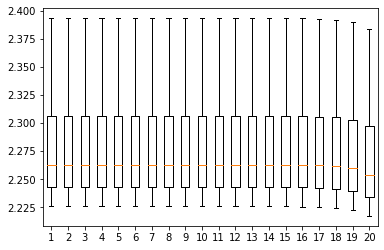

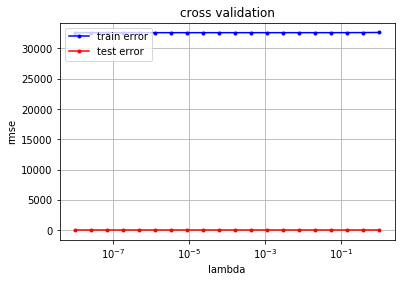

Test best error = 2.2772501812522163for lambda = 1.0
DEGREE = 2
Lambda = 1e-08
Current iteration=0, loss=58600.687222445216
Current iteration=100, loss=40016.6255080525rate = 4250.6441740069495

Current iteration=200, loss=45533.60732079285rate = 489.90692214044975

Current iteration=300, loss=41062.72508576178rate = 1871.8461087506003

Current iteration=400, loss=39026.383934850826rate = 5031.04699501393



C:\Users\L'empereur du sale\ML_REAL\cs433-ml\projects\project1\scripts\costs.py:33: RuntimeWarning: divide by zero encountered in log
  loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))


Current iteration=500, loss=nanrate = nan

Current iteration=600, loss=nanrate = nan

Current iteration=700, loss=nanrate = nan

Current iteration=800, loss=nanrate = nan

Current iteration=900, loss=nanrate = nan

Current iteration=1000, loss=nanrate = nan

Current iteration=1100, loss=nanrate = nan

Current iteration=1200, loss=nanrate = nan

Current iteration=1300, loss=nanrate = nan

Current iteration=1400, loss=nanrate = nan

Current iteration=1500, loss=nanrate = nan

Current iteration=1600, loss=nanrate = nan

Current iteration=1700, loss=nanrate = nan

Current iteration=1800, loss=nanrate = nan

Current iteration=1900, loss=nanrate = nan

Current iteration=2000, loss=nanrate = nan

Current iteration=2100, loss=nanrate = nan

Current iteration=2200, loss=nanrate = nan

Current iteration=2300, loss=nanrate = nan

Current iteration=2400, loss=nanrate = nan

Current iteration=2500, loss=nanrate = nan

Current iteration=2600, loss=nanrate = nan

Current iteration=2700, loss=nanrate 

Current iteration=5500, loss=31469.199980810263rate = 4652.645321216471

Current iteration=5600, loss=33562.26653863642rate = -5379.8146535929845

Current iteration=5700, loss=32897.025340201406rate = -978.5429334886248

Current iteration=5800, loss=34107.737371423216rate = -5856.683648487626

Current iteration=5900, loss=39602.065043787035rate = -994.580671671818

Current iteration=6000, loss=33709.02730972737rate = -5566.731137343817

Current iteration=6100, loss=31902.095260224396rate = -74.33339236636311

Current iteration=6200, loss=31318.78227727875rate = 3349.9875803486393

Current iteration=6300, loss=31320.503593155885rate = 4627.790010215729

Current iteration=6400, loss=37220.82703108992rate = 270.3973375988571

Current iteration=6500, loss=31775.522568750654rate = -85.1192900588212

Current iteration=6600, loss=32183.079024779046rate = -178.17574524565134

Current iteration=6700, loss=31655.54926370506rate = -3736.056615953028

Current iteration=6800, loss=32265.98291044574

Current iteration=500, loss=nanrate = nan

Current iteration=600, loss=nanrate = nan

Current iteration=700, loss=nanrate = nan

Current iteration=800, loss=nanrate = nan

Current iteration=900, loss=nanrate = nan

Current iteration=1000, loss=nanrate = nan

Current iteration=1100, loss=nanrate = nan

Current iteration=1200, loss=nanrate = nan

Current iteration=1300, loss=nanrate = nan

Current iteration=1400, loss=nanrate = nan

Current iteration=1500, loss=nanrate = nan

Current iteration=1600, loss=nanrate = nan

Current iteration=1700, loss=nanrate = nan

Current iteration=1800, loss=nanrate = nan

Current iteration=1900, loss=nanrate = nan

Current iteration=2000, loss=nanrate = nan

Current iteration=2100, loss=nanrate = nan

Current iteration=2200, loss=nanrate = nan

Current iteration=2300, loss=nanrate = nan

Current iteration=2400, loss=nanrate = nan

Current iteration=2500, loss=nanrate = nan

Current iteration=2600, loss=nanrate = nan

Current iteration=2700, loss=nanrate 

Current iteration=8800, loss=nanrate = nan

Current iteration=8900, loss=nanrate = nan

Current iteration=9000, loss=nanrate = nan

Current iteration=9100, loss=nanrate = nan

Current iteration=9200, loss=nanrate = nan

Current iteration=9300, loss=nanrate = nan

Current iteration=9400, loss=nanrate = nan

Current iteration=9500, loss=nanrate = nan

Current iteration=9600, loss=nanrate = nan

Current iteration=9700, loss=nanrate = nan

Current iteration=9800, loss=nanrate = nan

Current iteration=9900, loss=nanrate = nan

last loss =nanafter 9999iterations
Current iteration=0, loss=58633.398827676676
Current iteration=100, loss=39760.16517070289rate = 4783.567072603306

Current iteration=200, loss=41880.268533745024rate = -7297.884156056221

Current iteration=300, loss=39652.47322810379rate = -5931.777743714949

Current iteration=400, loss=36811.00383051872rate = -3573.4914463578534

Current iteration=500, loss=41977.46274874893rate = -8495.881725084626

Current iteration=600, loss=358

Current iteration=500, loss=nanrate = nan

Current iteration=600, loss=nanrate = nan

Current iteration=700, loss=nanrate = nan

Current iteration=800, loss=nanrate = nan

Current iteration=900, loss=nanrate = nan

Current iteration=1000, loss=nanrate = nan

Current iteration=1100, loss=nanrate = nan

Current iteration=1200, loss=nanrate = nan

Current iteration=1300, loss=nanrate = nan

Current iteration=1400, loss=nanrate = nan

Current iteration=1500, loss=nanrate = nan

Current iteration=1600, loss=nanrate = nan

Current iteration=1700, loss=nanrate = nan

Current iteration=1800, loss=nanrate = nan

Current iteration=1900, loss=nanrate = nan

Current iteration=2000, loss=nanrate = nan

Current iteration=2100, loss=nanrate = nan

Current iteration=2200, loss=nanrate = nan

Current iteration=2300, loss=nanrate = nan

Current iteration=2400, loss=nanrate = nan

Current iteration=2500, loss=nanrate = nan

Current iteration=2600, loss=nanrate = nan

Current iteration=2700, loss=nanrate 

Current iteration=8900, loss=nanrate = nan

Current iteration=9000, loss=nanrate = nan

Current iteration=9100, loss=nanrate = nan

Current iteration=9200, loss=nanrate = nan

Current iteration=9300, loss=nanrate = nan

Current iteration=9400, loss=nanrate = nan

Current iteration=9500, loss=nanrate = nan

Current iteration=9600, loss=nanrate = nan

Current iteration=9700, loss=nanrate = nan

Current iteration=9800, loss=nanrate = nan

Current iteration=9900, loss=nanrate = nan

last loss =nanafter 9999iterations
Lambda = 6.951927961775605e-08
Current iteration=0, loss=58600.68722244545
Current iteration=100, loss=38985.44471345491rate = 4873.460331390379

Current iteration=200, loss=38418.61711089523rate = 3113.709870706167

Current iteration=300, loss=41563.1955928959rate = -7505.918205312722

Current iteration=400, loss=44193.12508853465rate = -9903.408368365992

Current iteration=500, loss=nanrate = nan

Current iteration=600, loss=nanrate = nan

Current iteration=700, loss=nanrate

Current iteration=4400, loss=33548.754798994516rate = -471.25568443459997

Current iteration=4500, loss=32752.16725351732rate = -4400.173983143475

Current iteration=4600, loss=39904.38966748966rate = -1188.2293909627224

Current iteration=4700, loss=32984.83892690707rate = -248.87042731885958

Current iteration=4800, loss=31735.284911973526rate = 4646.330035877363

Current iteration=4900, loss=33425.1946928016rate = -621.53275840672

Current iteration=5000, loss=31829.728058908255rate = 3603.58912243924

Current iteration=5100, loss=31615.507617822528rate = 3428.82052066056

Current iteration=5200, loss=31575.343322511562rate = -2471.931745132755

Current iteration=5300, loss=32418.686026627078rate = 2522.622536589235

Current iteration=5400, loss=31517.39221122213rate = -3.5396815844942466

Current iteration=5500, loss=39685.33257426014rate = -1118.194960328401

Current iteration=5600, loss=31698.890452968466rate = 4609.100616390635

Current iteration=5700, loss=32923.15209024626rate

Current iteration=9000, loss=nanrate = nan

Current iteration=9100, loss=nanrate = nan

Current iteration=9200, loss=nanrate = nan

Current iteration=9300, loss=nanrate = nan

Current iteration=9400, loss=nanrate = nan

Current iteration=9500, loss=nanrate = nan

Current iteration=9600, loss=nanrate = nan

Current iteration=9700, loss=nanrate = nan

Current iteration=9800, loss=nanrate = nan

Current iteration=9900, loss=nanrate = nan

last loss =nanafter 9999iterations
Current iteration=0, loss=58658.33118816824
Current iteration=100, loss=39937.37659421752rate = 2729.012646763833

Current iteration=200, loss=38193.64287398647rate = 3174.8943643171224

Current iteration=300, loss=38385.30134929759rate = -5065.280440707422

Current iteration=400, loss=37623.54032108738rate = -1805.4404185611784

Current iteration=500, loss=nanrate = nan

Current iteration=600, loss=nanrate = nan

Current iteration=700, loss=nanrate = nan

Current iteration=800, loss=nanrate = nan

Current iteration=900

KeyboardInterrupt: 

In [18]:
#lambda_=0.0000001
k_fold=4
seed=5
degree=5 #will -1 as range exclude last elem
lower_lambda=-8
upper_lambda=0

weights_0, loss_0, deg0 = cross_validation_best_weight(y0, tX0_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet0")
weights_1, loss_1, deg1 = cross_validation_best_weight(y1, tX1_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet1")
weights_2, loss_2, deg2 = cross_validation_best_weight(y2, tX2_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet2")
weights_3, loss_3, deg3 = cross_validation_best_weight(y3, tX3_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet3")

# Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
print(tX_test.shape, ids_test.shape)

In [ ]:
_, tX0_te, id0_te = load_data_jet_number("../data/test.csv", 0)
_, tX1_te, id1_te = load_data_jet_number("../data/test.csv", 1)
_, tX2_te, id2_te = load_data_jet_number("../data/test.csv", 2)
_, tX3_te, id3_te = load_data_jet_number("../data/test.csv", 3)
tX0_te_standardized, tX0_te_mean, tX0_te_std= standardize(tX0_te)
tX1_te_standardized, tX1_te_mean, tX1_te_std= standardize(tX1_te)
tX2_te_standardized, tX2_te_mean, tX2_te_std= standardize(tX2_te)
tX3_te_standardized, tX3_te_mean, tX3_te_std= standardize(tX3_te)

In [ ]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
y0_pred = predict_labels(weights_0, build_poly(tX0_te_standardized,deg0))
y1_pred = predict_labels(weights_1, build_poly(tX1_te_standardized,deg1))
y2_pred = predict_labels(weights_2, build_poly(tX2_te_standardized,deg2))
y3_pred = predict_labels(weights_3, build_poly(tX3_te_standardized,deg3))

In [ ]:
y_pred_all=np.concatenate([y0_pred,y1_pred,y2_pred,y3_pred])
ids_pred_all=np.concatenate([id0_te,id1_te,id2_te,id3_te])
y_and_ids=list(zip(*sorted(zip(ids_pred_all, y_pred_all))))
ids_test=y_and_ids[0]
y_pred=y_and_ids[1]

In [ ]:
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)